In [1]:
%load_ext cython
import numpy as np
import h5py
import pickle

In [2]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/gilles/gdrive/research/sandbox/learning-qcd-rnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=1.0, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array([e for e in tree]).reshape(-1, 2)
        content = np.array([e for e in content]).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

In [16]:
# f = h5py.File("../data/w-vs-qcd/h5/w_100000.h5", "r")
f = h5py.File("../data/w-vs-qcd/h5/qcd_100000.h5", "r")
events = f["events"]

def cast(event):
    a = np.zeros((len(event), 4))
    for i, p in enumerate(event):
        a[i, 3] = p[0]
        a[i, 0] = p[1]
        a[i, 1] = p[2]
        a[i, 2] = p[3]
    return a

# fd = open("../data/w-vs-qcd/kt/kt-w.pickle", "wb")
# fd = open("../data/w-vs-qcd/kt/kt-qcd.pickle", "wb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-w.pickle", "wb")
fd = open("../data/w-vs-qcd/anti-kt/antikt-qcd.pickle", "wb")

for e in events:
    tree, content, mass, pt = cluster(cast(e), jet_algorithm=1)[0]  # dump highest pt jet only
    
    jet = {}
    
    jet["root_id"] = 0
    jet["tree"] = tree
    jet["content"] = content
    jet["mass"] = mass
    jet["pt"] = pt
    jet["energy"] = content[0, 3]

    px = content[0, 0]
    py = content[0, 1]
    pz = content[0, 2]
    p = (content[0, 0:3] ** 2).sum() ** 0.5
    eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
    phi = np.arctan2(py, px)
    
    jet["eta"] = eta
    jet["phi"] = phi
    
    pickle.dump(jet, fd, protocol=pickle.HIGHEST_PROTOCOL)
    
fd.close()

---

In [26]:
pts0 = []
pts1 = []

for e in events[:10000]:
    jets = cluster(cast(e), jet_algorithm=0)
    pt0 = jets[0][3]
    pt1 = jets[1][3]
    pts0.append(pt0)
    pts1.append(pt1)

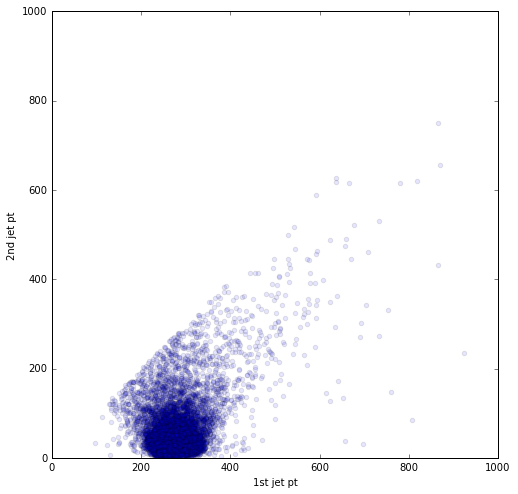

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(pts0, pts1, marker="o", alpha=0.1)
plt.xlabel("1st jet pt")
plt.ylabel("2nd jet pt")
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()